In [ ]:
# Loading libraries for CNN and basic array management.
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import *
from keras.layers import *
import numpy as np
import pandas as pd
import tensorflow as tf
from numpy.random import *
from numpy import *

# **General Adversial Networks (GAN's)**
* GAN'S are generative models that are capable of image generation, image translation, style transfer, and many more fascinating applications.
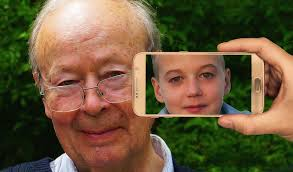

## What are generator models? ##
* A discriminator is a model that discriminates or classsifies the data into categories.
* A generator is a model that generates new data from the data it is trained on.

## Science of generation ##
* In general, there are various ways to design generator models. The phenomena happening inside a generator is, it learns the distribution (patterns) in the training data to produce new data.
* Knowing the exact distribution is not necessary to produce new samples.<br>
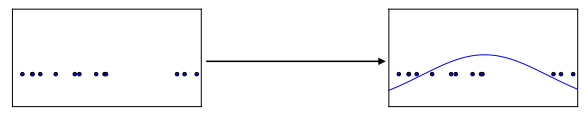
*  In some cases, the model estimates the real images distribution explicitly,as shown in figure and in other cases, the model is only able to generate samples,some models are able to do both.

## WHY GAN?? ##
* Some traditional means of training machine learning models, such as minimizing the mean squared error between a desired output and the model’s predicted output, are not able to train models that can produce multiple different correct answers.
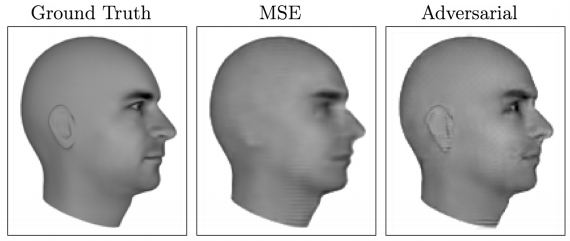
* When the model is trained using mean squared error between the actual next frame and the model’s predicted next frame. The model is forced to choose a single answer for what the next frame will look like. Because there are many possible futures, corresponding to slightly different positions of the head, the single answer that the model chooses corresponds to an average over many slightly different images. This causes the ears to practically vanish and the eyes to become blurry. Using an additional GAN loss, the image on the right is able to understand that there are many possible outputs, each of which is sharp and recognizable as a realistic, detailed image.
* Also many tasks intrinsically require realitic generation of samples from some distribution.


## How they work ? ##
* The basic idea of GANs is to set up a game between two players (Hence Adversial). 
* One of them is called the generator. The generator creates samples that are intended to come from the same distribution as the training data. The other player is the discriminator. The discriminator examines samples to determine whether they are real or fake.
* The discriminator learns using traditional supervised learning techniques, dividing inputs into two classes (real or fake) and the generator is trained to fool the discriminator. 
* We can think of the generator as being like a counterfeiter, trying to make fake money, and the discriminator as being like police, trying to allow legitimate money and catch counterfeit money.
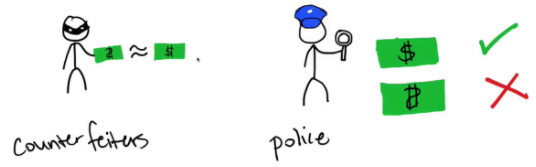
* To succeed in this game, the counterfeiter must learn to make money that is indistinguishable from genuine money, and the generator network must learn to create samples that are drawn from the same distribution as the training data.

# Creating GAN for generating hand written digits.
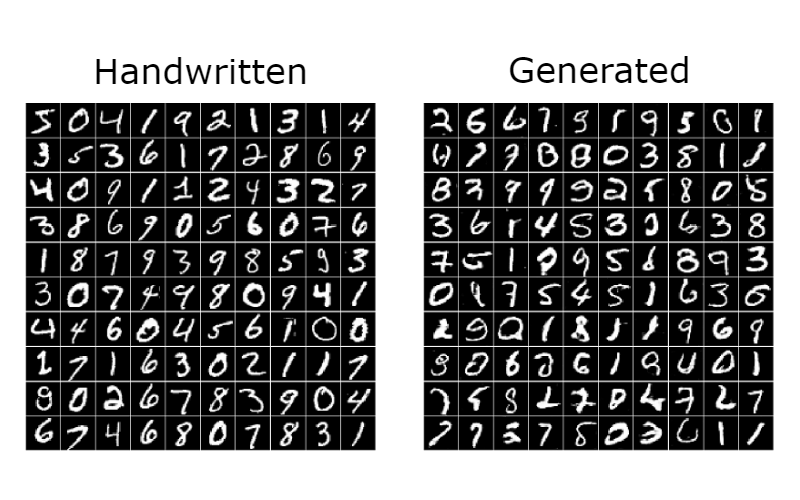

## DATASET ##
* In this notebook we will create a GAN to create new handwritten digits.
* MNIST handwritten dataset contains many grey scale images of digits of size (28 X 28).
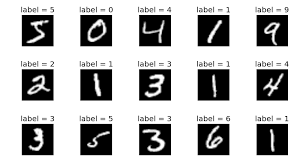
* This dataset can be loaded in keras. These are the real samples we give to the discriminator.

In [ ]:
def load_real_samples():
    # load mnist dataset
    X_train = pd.read_csv("../input/mnist-original/mnist_train.csv")
    X_train = X_train.iloc[:,:-1]
    X = X_train.values.reshape(-1,28,28)
    # expand to 3d,add channels dimension
    X = np.expand_dims(X, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X

## Generating real samples from Dataset ##
* The model will be updated in batches, specifically with a collection of real samples and a collection of generated samples. On training, an epoch is defined as one pass through the entire training dataset.
*  The generate real samples() function below will take the training dataset as an argument and will select a random subsample of images; it will also return class labels for the sample, specifically a class label of 1, to indicate real images.

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

## Generating Fake samples
* First, we should have latent points to give to generator to produce fake samples.
* The array of random numbers can be generated and then be reshaped into samples, that is n rows with 100 elements per row. 
* The generate latent points() function below implements this and generates the desired number of points in the latent space that can be used as input to the generator model.
* Then it is input to generator to generate new samples.

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

## Discriminator ##
* The discriminator is a typical CNN we use to classify the images to their labels, but here we classify them as real or fake.
* We train the discriminator using some real and some fake images. So its output is "1" for real and "0" for fake and the input is real and fake images.
* There is some particular configuration of hyperparameters that are seen by the authors to work best and we will use them.
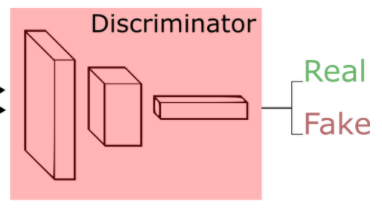

In [ ]:
def define_discriminator(input_dim = (28,28,1)):
  # DEFINE MODEL
    model = Sequential()
    model.add(Conv2D(64,(3,3),strides=(2,2),padding='same',input_shape= input_dim))
    model.add(Activation(LeakyReLU(0.2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(64,(3,3),strides=(2,2),padding='same'))
    model.add(Activation(LeakyReLU(0.2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    # COMPILE MODEL
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

## GENERATOR ##
* The generator takes some random vector as input and generates a new image. This random space has no meaning but the generator imagines and assumes some meaning to it while learning.
* The image generation is exactly done by **UPSAMPLING**. In this upsampling, we make a 2d array twice or thrice its size and fill information to it using the CNN filters which are trained during learning.
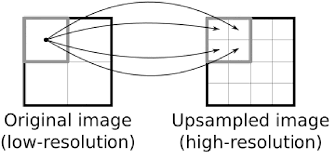
* The **Conv2DTranspose** parameter provides this functionality.
* The Conv2DTranspose layer can be configured with a stride of (2 × 2) that will quadruple the area of the input feature maps (double their width and height dimensions).
* This can be repeated to arrive at our 28×28 output image.The output layer of the model is a Conv2D with one filter and a kernel size of 7 × 7 and ‘same’ padding, designed to create a single feature map and preserve its dimensions at 28 × 28 pixels.
* The overall architecture looks like this.

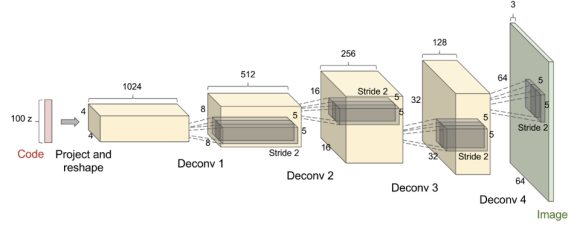

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

## The GAN Model ##
* A new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space and generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.
* To be clear, we are not talking about a new third model, just a new logical model that uses the already-defined layers and weights from the standalone generator and discriminator models. Only the discriminator is concerned with distinguishing between real and fake examples, therefore the discriminator model can be trained in a standalone manner on examples of each.
* The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they cannot be updated and overtrained on fake examples.
* We want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class = 1). Why would we want to do this? We can imagine that the discriminator will then classify the generated samples as not real (class = 0) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating good fake samples.
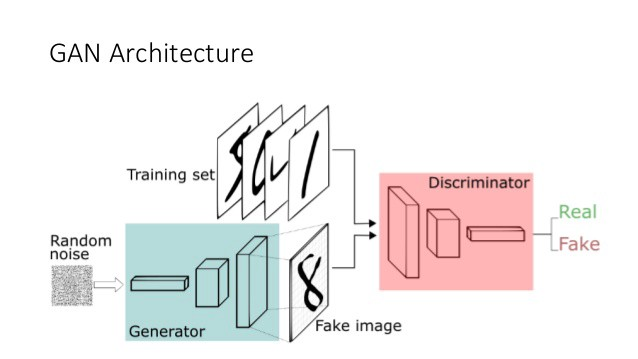

## The Loss Function ##
* The loss function of both discriminator and generator is driven by discriminator.
* We have used the non-saturation loss function and is explained in the above cell.

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

## Training the GAN Model ##
* We first update the discriminator model with real and fake samples, then update the generator via the composite model.
* The number of batches within an epoch is defined by how many times the batch size divides into the training dataset. We have a dataset size of 60K samples and a batch size of 256, so with rounding down, there are 60000/256 or 234 batches per epoch.
* The discriminator model is updated once per batch by combining one half a batch (128) of fake and real (128) examples into a single batch via the vstack() NumPy function. You could update the discriminator with each half batch separately.

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    d_loss = 0
    g_loss = 0
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
        # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator✬s error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
        # summarize loss on this epoch
        print('>%d, d=%.3f, g=%.3f' % (i+1, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

## Driver Code ##

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

## Lets test and have an eye feast! 

In [ ]:
# generate a single latent point
latent_points = generate_latent_points(100, 1)
# generate images
X = g_model.predict(latent_points)
# plot the result
plt.imshow(X[0,:,:,0],cmap='gray')

* Some of the reference to the code is taken from the book https://machinelearningmastery.com/generative_adversarial_networks/ 
* The concepts are learnt and taken from the original research paper https://arxiv.org/abs/1406.2661

# If you have learnt something atleast from the notebook and found your time worth, please consider upvoting. #

# The next series of this notebook will be on Conditional GAN's<br> Thank You